# 2. Projekat iz predmeta **Mašinsko učenje**
**Dataset:**  
[E-commerce Cosmetic Products](https://www.kaggle.com/datasets/devi5723/e-commerce-cosmetics-dataset)

U ovom projektu bavimo se problemom klasterizacije podataka, sa ciljem identifikacije sličnih proizvoda u e-commerce okruženju. 
Skup podataka sadrži informacije o kozmetičkim proizvodima koji se prodaju putem online platformi, uključujući njihove cenovne karakteristike, popularnost i osnovne opisne atribute.

## Osobine (feature-i)
Za potrebe klasterizacije korišćen je podskup atributa koji su relevantni za segmentaciju proizvoda u e-commerce sistemu:
- Price - cena proizvoda
- Rating - prosečna ocena proizvoda
- Number of Ratings - broj korisničkih ocena 
- Category - glavna kategorija proizvoda
- Subcategory - podkategorija proizvoda

Numeričke osobine korišćene su za analizu cenovnog ranga i popularnosti proizvoda, dok su kategorijske osobine omogućile grupisanje proizvoda prema njihovim osnovnim karakteristikama.

Cilj ovog projekta je primena i upoređivanje različitih algoritama za klasterizaciju u cilju:
identifikacije različitih tržišnih segmenata proizvoda (npr. niskobudžetni, srednji i premium proizvodi),
analize sličnosti između proizvoda na osnovu cene, popularnosti i osnovnih karakteristika,
ispitivanja uticaja preprocesiranja podataka, redukcije dimenzionalnosti i obrade outlier-a na kvalitet dobijenih klastera.

Očekivani klasteri:                                                                                                                                            
  1. Premium Quality - visoka cena, visok rating, manje recenzija                                                                                                
  2. Bestsellers - srednja cena, visok rating, mnogo recenzija                                                                                                  
  3. Budget Friendly - niska cena, okej rating, dosta recenzija                                                                                                  
  4. Overpriced - visoka cena, nizak rating                                                                                                          
  5. Hidden Gems - niska cena, visok rating, malo recenzija   

## 1. Setup i učitavanje
### 1.1. Import biblioteka i setovanje konstantni

In [583]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

# Paleta boja: roze, plava, ljubičasta
COLORS = {
    'pink': '#E91E63',
    'pink_light': '#F48FB1',
    'purple': '#9C27B0',
    'purple_light': '#CE93D8',
    'blue': '#5C6BC0',
    'blue_light': '#9FA8DA',
}

COLOR_PALETTE = ['#E91E63', '#9C27B0', '#5C6BC0', '#F48FB1', '#CE93D8', '#9FA8DA']

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (16, 12)

### 1.2. Učitavanje podataka i pregled strukture

In [584]:
dataset = pd.read_csv('data/E-commerce-cosmetic-dataset.csv', encoding='latin-1')

dataset.info()

dataset.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12615 entries, 0 to 12614
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  12615 non-null  object 
 1   website       12615 non-null  object 
 2   country       12615 non-null  object 
 3   category      12615 non-null  object 
 4   subcategory   12615 non-null  object 
 5   title-href    12615 non-null  object 
 6   price         12298 non-null  float64
 7   brand         12615 non-null  object 
 8   ingredients   6600 non-null   object 
 9   form          12615 non-null  object 
 10  type          9934 non-null   object 
 11  color         10626 non-null  object 
 12  size          9449 non-null   object 
 13  rating        10548 non-null  object 
 14  noofratings   12156 non-null  object 
dtypes: float64(1), object(14)
memory usage: 1.4+ MB


,price
count,12298.000000
mean,2281.180935
std,3158.690307
min,1.700000
25%,499.000000
50%,1307.200000
75%,2859.500000
max,94099.000000


In [585]:
dataset.head()

,product_name,website,country,category,subcategory,title-href,price,brand,ingredients,form,type,color,size,rating,noofratings
0,"Carlton London Incense Eau da parfum, Premium ...",Flipkart,India,body,perfume,https://www.amazon.in/Carlton-London-Limited-I...,599.0,Carlton London,NaN,aerosol,NaN,"Top Note: Orange Blossom, Blackberry | Heart N...",100,3.9,19
1,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,149.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,031"
2,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,Flipkart,India,body,perfume,https://www.amazon.in/CHARLENE-SPRAY-MIST-PERF...,298.0,Charlene,NaN,aerosol,NaN,Unit count type:,30,4.4,"4,072"
3,DENVER Black Code Perfume - 60 | Eau de Parfum...,Flipkart,India,body,perfume,https://www.amazon.in/DENVER-Black-Code-Perfum...,245.0,Denver,NaN,aerosol,NaN,Long-Lasting Scent,60,4.2,61
4,Denver Hamilton Perfume - 100 | Long Lasting P...,Flipkart,India,body,perfume,https://www.amazon.in/Denver-Perfume-Hamilton-...,422.0,Denver,NaN,aerosol,NaN,Long-Lasting Scent,100,4.3,342


## 2 Preprocesiranje podataka
### 2.1 Konverzija valute (INR → EUR)

Dataset sadrži cene u indijskim rupijama (INR). Konvertujemo u evre (EUR) za lakšu interpretaciju.

In [586]:
INR_TO_EUR = 0.0094

dataset['price'] = dataset['price'] * INR_TO_EUR

print(f"\nStatistika cena u EUR:")
dataset.describe()


Statistika cena u EUR:


,price
count,12298.000000
mean,21.443101
std,29.691689
min,0.015980
25%,4.690600
50%,12.287680
75%,26.879300
max,884.530600


### 2.2 Uklanjanje duplikata

In [587]:
broj_duplikata = dataset.duplicated().sum()
print(f'Broj duplikata: {broj_duplikata}')
dataset = dataset.drop_duplicates()
print(f'Broj redova posle uklanjanja: {len(dataset)}')

Broj duplikata: 60
Broj redova posle uklanjanja: 12555


### 2.3 Uklanjanje nerelevantnih fičera
- Url do proizvoda
- Type i Form - već postoji kategorija i podkategorija
- Color - nerelevanta, takođe ima netačne vrednosti za tu kolonu

In [588]:
dataset = dataset.drop(columns=['title-href', 'type', 'color', 'form'])


### 2.3 Preprocesiranje kolona Rating i Number of Ratings
Kolone Rating i Number of Ratings su mešovite: 
- Number of Ratings sadrži vrednosti kao što su "No reviews", "New to Amazon", "Write a review", "X ratings" (X - broj ocena) i numeričke vrednosti.
- Rating sadrži vrednosti kao što su "X out of 5 stars"(X - vrednost ocene) i numeričke vrednosti gde nisu sve u opsegu od 1-5.

In [589]:
# Primeri problematičnih vrednosti u kolonama rating i noofratings

# ============================================================
# NOOFRATINGS - primeri
# ============================================================
noofratings_filters = {
    'No reviews': dataset['noofratings'].astype(str).str.lower().str.contains('no review', na=False),
    'New to Amazon': dataset['noofratings'].astype(str).str.lower().str.contains('new to amazon', na=False),
    'Write a review': dataset['noofratings'].astype(str).str.lower().str.contains('write a review', na=False),
    'X ratings (string)': dataset['noofratings'].astype(str).str.contains('rating', case=False, na=False),
    'Broj sa zarezom': dataset['noofratings'].astype(str).str.match(r'^\d+,\d+$', na=False),
}

rows = []
for opis, filter_mask in noofratings_filters.items():
    if filter_mask.sum() > 0:
        row = dataset[filter_mask][['product_name', 'rating', 'noofratings']].head(1).copy()
        row.insert(0, 'Tip vrednosti', opis)
        rows.append(row)

noofratings_examples = pd.concat(rows, ignore_index=True)
display(noofratings_examples)

# ============================================================
# RATING - primeri
# ============================================================
rating_filters = {
    'X out of 5 stars': dataset['rating'].astype(str).str.contains('out of 5', case=False, na=False),
    'Vrednost sa zarezom': dataset['rating'].astype(str).str.contains(r'^\d,\d+$', regex=True, na=False),
    'Vrednost > 5': pd.to_numeric(dataset['rating'], errors='coerce') > 5,
}

rows = []
for opis, filter_mask in rating_filters.items():
    if filter_mask.sum() > 0:
        row = dataset[filter_mask][['product_name', 'rating', 'noofratings']].head(1).copy()
        row.insert(0, 'Tip vrednosti', opis)
        rows.append(row)

rating_examples = pd.concat(rows, ignore_index=True)
display(rating_examples)

,Tip vrednosti,product_name,rating,noofratings
0,No reviews,Adbeni WATERPROFF LENGTH FIBER EXTENSION EYELI...,NaN,No reviews
1,New to Amazon,ATORSE Eyelash Eyebrow Dye Tint Cream Kit Eyeb...,NaN,New to Amazon
2,Write a review,Sweet Tobacco Spirits Spritzer,NaN,Write A Review
3,X ratings (string),Swiss Beauty High Coverage Waterproof Base Fou...,3.80,"1,165 ratings"
4,Broj sa zarezom,CHARLENE SPRAY MIST PERFUME 30 - INTIMATE (PAC...,4.4,"4,031"


,Tip vrednosti,product_name,rating,noofratings
0,X out of 5 stars,Supra Concealer Opaque Coverage Professional M...,2.8 out of 5 stars,10 ratings
1,Vrednost sa zarezom,Body Cupid Matcha Green Tea Shower Gel - 200,"1,374",NaN
2,Vrednost > 5,Kimirica Creme Bath Tropical Forest Summer Bod...,134,NaN


**Kolona Rating zavisi od Number of Ratings**
ako ne postoje ocene(na primer novi proizvod na sajtu), vrednost za Rating je prazno polje. 
- Uklanjaju se ocene koje prevazilaze vrednost 5 - ne možemo sa sigurnošću da ih obradimo sa 100% tačnošću.
- Stringovi u Number of Ratings se transformišu u numeričke vrednosti - izvlači se podatak o broju ocene iz stringa ili se dodeljuje vrednost 0.
- Uvodimo kolonu Has Reviews koja će razdvajati loše ocenjene proizvode od novih proizvoda ili proizvoda bez ocena.

In [590]:
import re

# ============================================================
# ČIŠĆENJE KOLONE: noofratings
# ============================================================
def clean_noofratings(value):
    """
    Čisti vrednosti u koloni noofratings:
    - "No reviews", "Write a review", "New to Amazon" → 0
    - "X ratings" → X (ekstraktuje broj)
    - "4,031" → 4031 (uklanja zareze)
    - NaN → NaN
    """
    if pd.isna(value):
        return np.nan
    
    value = str(value).strip().lower()
    
    zero_indicators = ['no reviews', 'write a review', 'new to amazon', 'be the first to review', '']
    if value in zero_indicators:
        return 0
    
    value = value.replace('ratings', '').replace('rating', '').strip()
    value = value.replace(',', '')
    
    try:
        return int(float(value))
    except ValueError:
        return np.nan

# ============================================================
# ČIŠĆENJE KOLONE: rating
# ============================================================
def clean_rating(value):
    """
    Čisti vrednosti u koloni rating:
    - Zamenjuje zarez sa tačkom (1,8473 → 1.8473)
    - Ocene van opsega 1.0 - 5.0 se uklanjaju (NaN), bez heurističkog popravljanja
    """
    if pd.isna(value):
        return np.nan

    value_str = str(value).strip().replace(',', '.')

    try:
        rating = float(value_str)
    except ValueError:
        return np.nan

    if rating < 1.0 or rating > 5.0:
        return np.nan

    return rating

# ============================================================
# PRIMENA ČIŠĆENJA
# ============================================================
print("Pre čišćenja:")
print(f"  rating:      {dataset['rating'].notna().sum()} non-null, tip: {dataset['rating'].dtype}")
print(f"  noofratings: {dataset['noofratings'].notna().sum()} non-null, tip: {dataset['noofratings'].dtype}")

# 1. Čišćenje noofratings
dataset['noofratings'] = dataset['noofratings'].apply(clean_noofratings)
dataset['noofratings'] = dataset['noofratings'].astype('Int64')

# 2. Konverzija rating
dataset['rating'] = dataset['rating'].apply(clean_rating)

# 3. Kreiranje flag-a has_reviews
dataset['has_reviews'] = (dataset['noofratings'].fillna(0) > 0).astype(int)

# 4. Logika: ako noofratings == 0 ili NA, rating nije validan
dataset.loc[(dataset['noofratings'] == 0) | (dataset['noofratings'].isna()), 'rating'] = np.nan

print("\nPosle čišćenja:")
print(f"  rating:      {dataset['rating'].notna().sum()} non-null, tip: {dataset['rating'].dtype}")
print(f"  noofratings: {dataset['noofratings'].notna().sum()} non-null, tip: {dataset['noofratings'].dtype}")
print(f"  has_reviews: nova kolona kreirana")

print("\n" + "="*60)
print("STATISTIKE POSLE ČIŠĆENJA:")
print("="*60)
print(dataset[['price', 'rating', 'noofratings']].describe())

print("\n" + "="*60)
print("RATING KOLONA - SADA U OPSEGU 1.0-5.0:")
print("="*60)
print(f"Min: {dataset['rating'].min():.2f}")
print(f"Max: {dataset['rating'].max():.2f}")
print(f"Mean: {dataset['rating'].mean():.2f}")

Pre čišćenja:
  rating:      10494 non-null, tip: object
  noofratings: 12102 non-null, tip: object

Posle čišćenja:
  rating:      10391 non-null, tip: float64
  noofratings: 12102 non-null, tip: Int64
  has_reviews: nova kolona kreirana

STATISTIKE POSLE ČIŠĆENJA:
              price        rating  noofratings
count  12238.000000  10391.000000      12102.0
mean      21.485583      4.137172  1036.605354
std       29.751437      0.525300  6705.413616
min        0.015980      1.000000          0.0
25%        4.690600      4.000000          8.0
50%       12.287680      4.200000         31.0
75%       26.879300      4.500000       289.75
max      884.530600      5.000000     220040.0

RATING KOLONA - SADA U OPSEGU 1.0-5.0:
Min: 1.00
Max: 5.00
Mean: 4.14


In [591]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12555 entries, 0 to 12614
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  12555 non-null  object 
 1   website       12555 non-null  object 
 2   country       12555 non-null  object 
 3   category      12555 non-null  object 
 4   subcategory   12555 non-null  object 
 5   price         12238 non-null  float64
 6   brand         12555 non-null  object 
 7   ingredients   6547 non-null   object 
 8   size          9409 non-null   object 
 9   rating        10391 non-null  float64
 10  noofratings   12102 non-null  Int64  
 11  has_reviews   12555 non-null  int64  
dtypes: Int64(1), float64(2), int64(1), object(8)
memory usage: 1.3+ MB


### 3. Analiza podataka

#### 3.1 Analiza nedostajućih vrednosti

Nedostajuće vrednosti po kolonama:

             Nedostaje  Procenat (%)
ingredients       6008         47.85
size              3146         25.06
rating            2164         17.24
noofratings        453          3.61
price              317          2.52


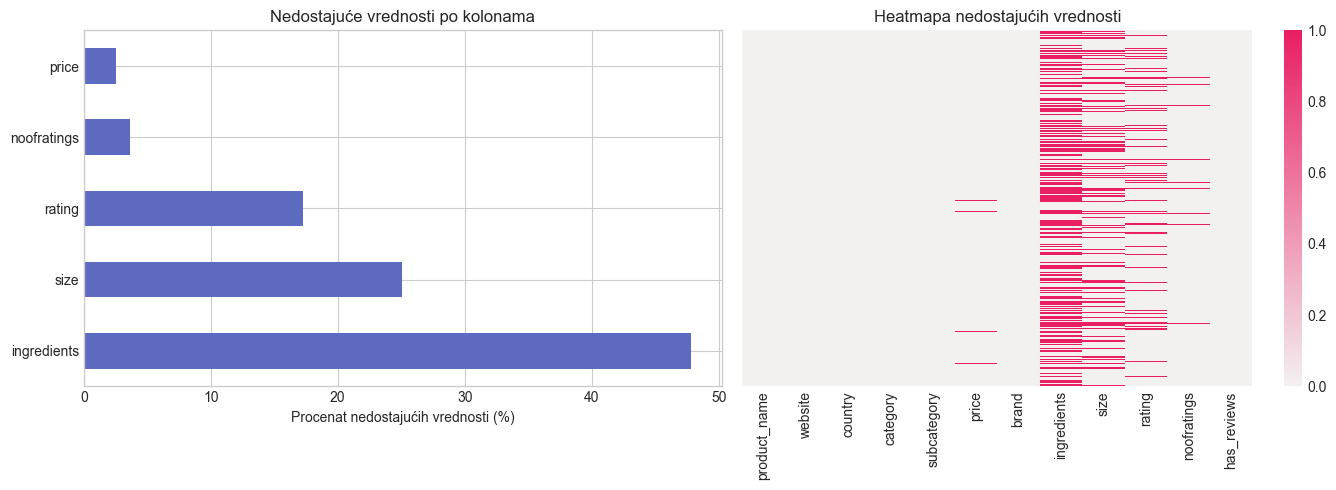

In [592]:
# Pregled nedostajućih vrednosti
missing_data = pd.DataFrame({
    'Nedostaje': dataset.isnull().sum(),
    'Procenat (%)': (dataset.isnull().sum() / len(dataset) * 100).round(2)
}).sort_values(by='Nedostaje', ascending=False)

print("Nedostajuće vrednosti po kolonama:\n")
print(missing_data[missing_data['Nedostaje'] > 0])

# Vizualizacija nedostajućih vrednosti
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
missing_data[missing_data['Nedostaje'] > 0]['Procenat (%)'].plot(
    kind='barh', 
    ax=axes[0],
    color=COLORS['blue']
)
axes[0].set_xlabel('Procenat nedostajućih vrednosti (%)')
axes[0].set_title('Nedostajuće vrednosti po kolonama')

# Heatmap prikaz missing values (uzorak od 500 redova za preglednost)
sample_idx = np.random.choice(len(dataset), size=len(dataset), replace=False)
cmap_custom = sns.light_palette(COLORS['pink'], as_cmap=True)
sns.heatmap(
    dataset.iloc[sample_idx].isnull(), 
    cbar=True, 
    yticklabels=False, 
    cmap=cmap_custom,
    ax=axes[1]
)
axes[1].set_title('Heatmapa nedostajućih vrednosti')

plt.tight_layout()
plt.show()

In [593]:
# Tabela: odnos broja redova sa/bez vrednosti za rating i noofratings (podela za 0 i NA)
n_total = len(dataset)
has_rating = dataset['rating'].notna()
has_noofratings = dataset['noofratings'].notna()
noofratings_is_0 = (dataset['noofratings'] == 0)   # tačno 0 (nije NA)
noofratings_is_na = dataset['noofratings'].isna()

# Rating prazan jer je noofratings = 0 odnosno NA (namerno postavljeno u prethodnom koraku)
rating_prazan_jer_noofratings_0 = (~has_rating) & noofratings_is_0
rating_prazan_jer_noofratings_na = (~has_rating) & noofratings_is_na
# Rating prazan iz drugih razloga (npr. van opsega 1-5)
rating_prazan_ostalo = (~has_rating) & has_noofratings & (dataset['noofratings'] > 0)

rating_noofratings_prazni = (~has_rating) & (~has_noofratings )

tabela_odnos = pd.DataFrame({
    'Opis': [
        'Redova bez vrednosti za rating (prazan rating)',
        'rating prazan jer je noofratings = 0',
        'rating prazan jer je noofratings = NA',
        'rating prazan iz drugih razloga (npr. van opsega)',
        'Redova sa vrednošću za noofratings (non-null)',
        'Redova sa noofratings = 0',
        'Redova sa noofratings = NA',
        'Redova sa noofratings > 0 (ima bar jednu ocenu)',
        'Redova gde su rating i noofratings prazni',
    ],
    'Broj redova': [
        (~has_rating).sum(),
        rating_prazan_jer_noofratings_0.sum(),
        rating_prazan_jer_noofratings_na.sum(),
        rating_prazan_ostalo.sum(),
        has_noofratings.sum(),
        noofratings_is_0.sum(),
        noofratings_is_na.sum(),
        (has_noofratings & (dataset['noofratings'] > 0)).sum(),
        rating_noofratings_prazni.sum(),
    ]
})
print("Odnos broja redova: rating i noofratings (podela: 0 vs NA)")
display(tabela_odnos)

Odnos broja redova: rating i noofratings (podela: 0 vs NA)


,Opis,Broj redova
0,Redova bez vrednosti za rating (prazan rating),2164
1,rating prazan jer je noofratings = 0,1417
2,rating prazan jer je noofratings = NA,453
3,rating prazan iz drugih razloga (npr. van opsega),294
4,Redova sa vrednošću za noofratings (non-null),12102
5,Redova sa noofratings = 0,1417
6,Redova sa noofratings = NA,453
7,Redova sa noofratings > 0 (ima bar jednu ocenu),10685
8,Redova gde su rating i noofratings prazni,453


Broj redova gde je rating prazan iz drugih razloga predstavlja mali procenat dataseta (<5%) i može se obrisati

In [594]:
rating_noofratings_prazni = (~has_rating) & noofratings_is_na
n_obrisano_prazni = rating_noofratings_prazni.sum()
redovi_za_izbaciti = rating_prazan_ostalo | rating_noofratings_prazni
dataset = dataset[~redovi_za_izbaciti].copy()
print(f"\nObrisano {rating_prazan_ostalo.sum()} redova (rating prazan uz noofratings > 0).")
print(f"Obrisano {n_obrisano_prazni} redova (nema ni rating ni number of ratings).")
print(f"Ukupno uklonjeno: {redovi_za_izbaciti.sum()} redova. Preostalo: {len(dataset)}")


Obrisano 294 redova (rating prazan uz noofratings > 0).
Obrisano 453 redova (nema ni rating ni number of ratings).
Ukupno uklonjeno: 747 redova. Preostalo: 11808


### 3.2 Brisanje neupotrebljivih fičera
- Ingredients - veliki procenat nedostajućih vrednosti, metode za popunjavanje praznih vrednosti bi unele samo šum


In [595]:
dataset = dataset.drop(columns=['ingredients'])

#### 3.2.1 Analiza Size fičera

Podaci u Size koloni su mešoviti i nepouzdani, u koloni postoje:
- vrednosti koje sadrže informaciju o mernoj jedinici(s, g, Gm, oz, fluid ounces, Kilos, milis)
- vrednosti bez informacije o mernoj jedinici <br>
Takođe, informacija size može da se pronađe unutar samog imena proizvoda, tj. u koloni Product Name, ali se ovi podaci ne poklapaju sa podacima iz kolone Size.

In [596]:
size_filters = {
    'Sa mernom jedinicom (fluid ounces)': dataset['size'].astype(str).str.contains('fluid|ounce', case=False, na=False),
    'Sa mernom jedinicom (Kilos)': dataset['size'].astype(str).str.contains('Kilos', case=False, na=False),
    'Sa mernom jedinicom (g / ml)': dataset['size'].astype(str).str.contains(r'\bg\b|ml|milis|Gm', case=False, regex=True, na=False),
    'Bez mernog jedinice (samo broj)': dataset['size'].astype(str).str.match(r'^\s*\d+\s*$', na=False),
    'Tekst koji nije veličina (npr. Unit count type)': dataset['size'].astype(str).str.contains('Unit count', case=False, na=False),
}

rows = []
for opis, filter_mask in size_filters.items():
    if filter_mask.sum() > 0:
        row = dataset[filter_mask][['product_name', 'size']].head(1).copy()
        row.insert(0, 'Tip vrednosti', opis)
        rows.append(row)

import re
def clear_name_size_mismatch(row):
    name = str(row['product_name'])
    size_val = str(row['size']).strip()
    if not size_val or size_val == 'nan': return False

    after_comma = re.findall(r',\s*(\d+)\s*$', name)     
    after_dash = re.findall(r'\s-\s*(\d+)\s*(\|\s*)?$', name)  
    nums_at_end = after_comma + [t[0] for t in after_dash]
    if not nums_at_end: return False
    size_num_match = re.match(r'^([\d.]+)', size_val)
    size_num_str = size_num_match.group(1) if size_num_match else size_val
    if size_num_str in nums_at_end or size_val in nums_at_end:
        return False
    try:
        size_num_f = float(size_num_str)
        for n in nums_at_end:
            if abs(size_num_f - int(n)) < 2: 
                return False
    except ValueError:
        pass
    return True
mismatch_mask = dataset.apply(clear_name_size_mismatch, axis=1)
if mismatch_mask.sum() > 0:
    row = dataset[mismatch_mask][['product_name', 'size']].head(1).copy()
    row.insert(0, 'Tip vrednosti', 'Size u imenu proizvoda ne poklapa se sa kolonom Size')
    rows.append(row)

size_examples = pd.concat(rows, ignore_index=True)
pd.set_option('display.max_colwidth', None)
display(size_examples)
pd.set_option('display.max_colwidth', 50) 

,Tip vrednosti,product_name,size
0,Sa mernom jedinicom (fluid ounces),Ajmal Aristocrat EDP 75 Long Lasting Scent Spray Fresh Perfume Gift For Men - Made In Dubai,2.5 Fluid Ounces
1,Sa mernom jedinicom (Kilos),Diego dalla Palma Milano Uv Daily Primer Make-Up Base Uv Spf 50+ Pa++++ Transparent,0.17 Kilos
2,Bez mernog jedinice (samo broj),"Carlton London Incense Eau da parfum, Premium Long Lasting & Refreshing Perfume for Men - 100",100
3,Size u imenu proizvoda ne poklapa se sa kolonom Size,"FERRARI Scuderia Forte Eau De Perfume for him, 125",30


Broj redova gde size može da se koristi

In [ ]:
size_has_unit = (
    dataset['size'].astype(str).str.contains(r'\bg\b|Gm|oz|fluid|ounce|Kilos|milis|ml|mL', case=False, regex=True, na=False)
)
n_size_with_unit = size_has_unit.sum()
print(f"Broj redova gde kolona Size sadrži mernu jedinicu (g, Gm, oz, fluid ounces, Kilos, milis, ml): {n_size_with_unit}")

def has_size_in_name(name):
    name = str(name)
    after_comma = re.findall(r',\s*(\d+)\s*$', name)
    after_dash = re.findall(r'\s-\s*(\d+)\s*(\|\s*)?$', name)
    return bool(after_comma or after_dash)

name_has_size = dataset['product_name'].apply(has_size_in_name)
n_name_with_size = name_has_size.sum()
print(f"Broj redova gde product_name na kraju sadrži veličinu (, broj ili \" - \" broj): {n_name_with_size}")

Broj redova gde kolona Size sadrži mernu jedinicu (g, Gm, oz, fluid ounces, Kilos, milis, ml): 174
Broj redova gde product_name na kraju sadrži veličinu (, broj ili " - " broj): 450


Broj redova kod kojih Size može da se koristi je mali(<5%) <br>
Uklanjanje kolone Size

In [598]:
dataset = dataset.drop(columns=['size'])

#### 2.2. Distribucija numeričkih kolona

Analiziramo distribucije kolona koje su ključne za klasterizaciju: `price`, `rating` i `noofratings`.

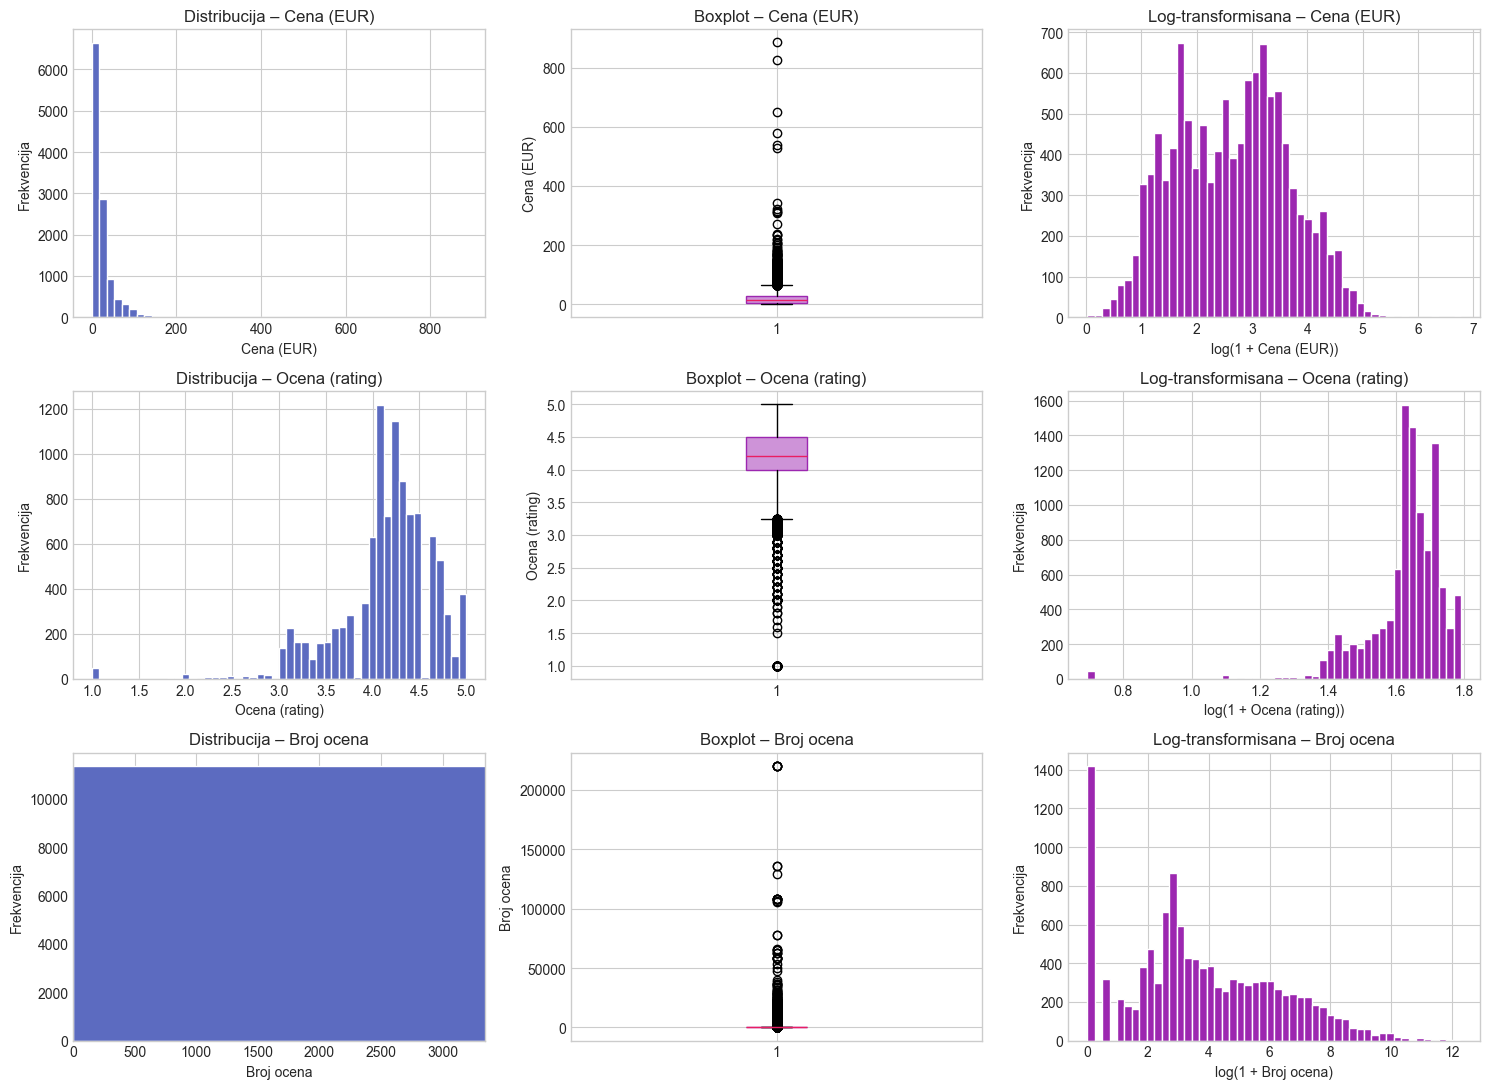


Statistički pregled numeričkih kolona:
              price        rating  noofratings
count  11580.000000  10391.000000      11808.0
mean      22.300573      4.137172   979.930894
std       29.939848      0.525300  6699.146129
min        0.015980      1.000000          0.0
25%        4.690600      4.000000          7.0
50%       13.823640      4.200000         28.5
75%       28.106000      4.500000        271.0
max      884.530600      5.000000     220040.0


In [599]:
fig, axes = plt.subplots(3, 3, figsize=(15, 11))

vars_config = [
    (dataset['price'].dropna(), 'Cena (EUR)'),
    (dataset['rating'].dropna(), 'Ocena (rating)'),
    (dataset['noofratings'].dropna(), 'Broj ocena'),
]

for row, (data, label) in enumerate(vars_config):
    # Histogram
    axes[row, 0].hist(data, bins=50, color=COLORS['blue'], edgecolor='white')
    axes[row, 0].set_xlabel(label)
    axes[row, 0].set_ylabel('Frekvencija')
    axes[row, 0].set_title(f'Distribucija – {label}')

    # Boxplot
    bp = axes[row, 1].boxplot(data, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor(COLORS['purple_light'])
    bp['boxes'][0].set_edgecolor(COLORS['purple'])
    bp['medians'][0].set_color(COLORS['pink'])
    axes[row, 1].set_ylabel(label)
    axes[row, 1].set_title(f'Boxplot – {label}')

    # Log-transformisana distribucija
    axes[row, 2].hist(np.log1p(data), bins=50, color=COLORS['purple'], edgecolor='white')
    axes[row, 2].set_xlabel(f'log(1 + {label})')
    axes[row, 2].set_ylabel('Frekvencija')
    axes[row, 2].set_title(f'Log-transformisana – {label}')

    # Ograničenje x-ose za bolju vizualizaciju (noofratings)
    if row == 2:
        x_max = data.quantile(0.95)
        axes[row, 0].set_xlim(0, x_max)

plt.tight_layout()
plt.show()

# Statistički pregled
print("\nStatistički pregled numeričkih kolona:")
print(dataset[['price', 'rating', 'noofratings']].describe())

#### 2.3. Analiza kategorijskih kolona

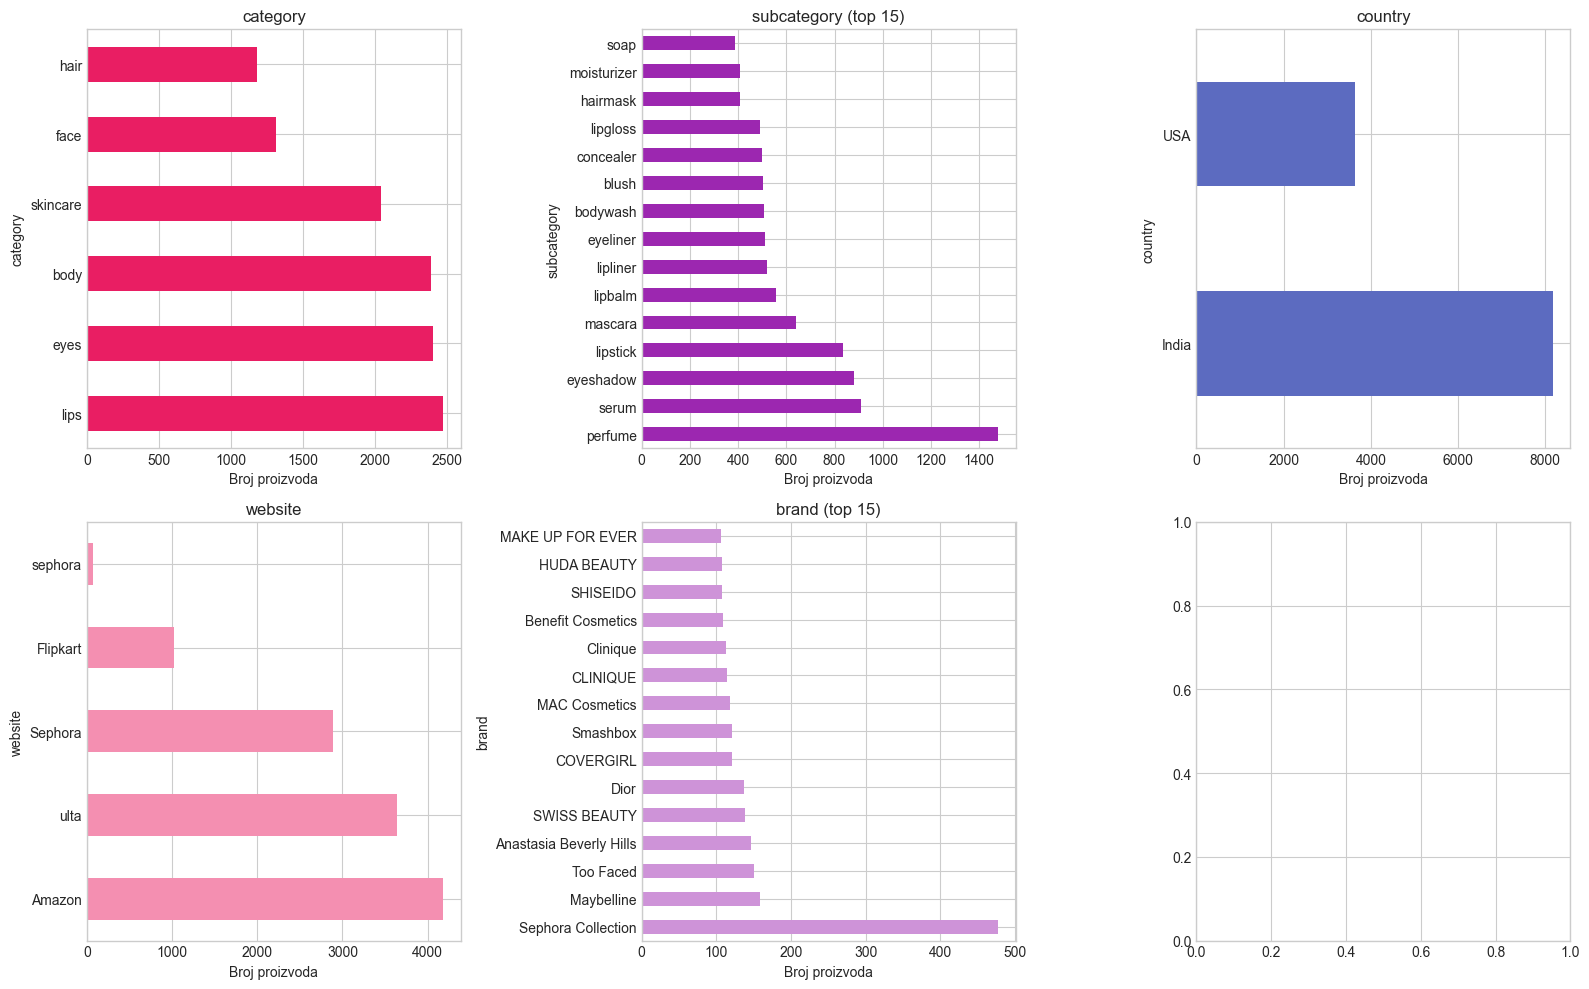

In [600]:
# Kategoričke kolone za analizu
categorical_cols = ['category', 'subcategory', 'country', 'website', 'brand']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    value_counts = dataset[col].value_counts()
    
    # Za kolone sa mnogo kategorija, prikaži top 15
    if len(value_counts) > 15:
        value_counts = value_counts.head(15)
        title = f'{col} (top 15)'
    else:
        title = col
    

    color = COLOR_PALETTE[idx % len(COLOR_PALETTE)]
    value_counts.plot(kind='barh', ax=axes[idx], color=color)
    axes[idx].set_title(title)
    axes[idx].set_xlabel('Broj proizvoda')

plt.tight_layout()
plt.show()

In [601]:
# Sumarni pregled kategoričkih kolona
print("Broj jedinstvenih vrednosti po kategoričkoj koloni:\n")
for col in categorical_cols:
    unique_count = dataset[col].nunique()
    print(f"{col}: {unique_count} jedinstvenih vrednosti")

Broj jedinstvenih vrednosti po kategoričkoj koloni:

category: 6 jedinstvenih vrednosti
subcategory: 36 jedinstvenih vrednosti
country: 2 jedinstvenih vrednosti
website: 5 jedinstvenih vrednosti
brand: 1645 jedinstvenih vrednosti


#### 2.4. Zaključci EDA

Na osnovu sprovedene eksploratorne analize, identifikovani su sledeći ključni uvidi:

**Nedostajuće vrednosti:**
- `ingredients` ima najviše nedostajućih vrednosti (~48%) - nije pogodna za klasterizaciju
- `type`, `rating`, `color` imaju značajan procenat nedostajućih vrednosti
- `price` ima mali procenat (~2.5%) nedostajućih vrednosti

**Distribucije:**
- `price` ima izrazito desno zakošenu (right-skewed) distribuciju sa outlierima
- Log-transformacija cene daje približno normalnu distribuciju
- `rating` i `noofratings` su očišćeni i konvertovani u numerički format

**Kategoričke varijable:**
- `brand` ima previše jedinstvenih vrednosti - nije pogodna za one-hot encoding
- `category`, `subcategory`, `form` imaju manji broj kategorija - pogodne za analizu
- Dataset pokriva uglavnom indijsko tržište (Flipkart)

**Preporuke za preprocessing:**
1. Razmotriti log-transformaciju za `price`
2. Dropovati kolone sa previše nedostajućih vrednosti (`ingredients`, `type`, `color`)

In [602]:
# Export očišćenog dataseta u CSV za proveru
dataset.to_csv('data/cleaned_dataset.csv', index=False)
print(f"Dataset exportovan u 'data/cleaned_dataset.csv'")
print(f"Broj redova: {len(dataset)}")
print(f"Kolone: {list(dataset.columns)}")

Dataset exportovan u 'data/cleaned_dataset.csv'
Broj redova: 11808
Kolone: ['product_name', 'website', 'country', 'category', 'subcategory', 'price', 'brand', 'rating', 'noofratings', 'has_reviews']
